<a href="https://colab.research.google.com/github/sawank930/COVID-19/blob/master/modiefied_darkcovidnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/8h65ywd2jr-3.zip

--2020-11-27 16:08:13--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/8h65ywd2jr-3.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.61.104
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.61.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3997547036 (3.7G) [application/octet-stream]
Saving to: ‘8h65ywd2jr-3.zip’

8h65ywd2jr-3.zip    100%[===================>]   3.72G  21.9MB/s    in 2m 59s  

2020-11-27 16:11:12 (21.3 MB/s) - ‘8h65ywd2jr-3.zip’ saved [3997547036/3997547036]



In [ ]:
!unzip 8h65ywd2jr-3.zip

Archive:  8h65ywd2jr-3.zip
  inflating: COVID-19 Dataset.zip    


In [ ]:
# importing required modules 
from zipfile import ZipFile 

# specifying the zip file name 
file_name = '/content/COVID-19 Dataset.zip'

# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
	# printing all the contents of the zip file 
	zip.printdir() 

	# extracting all the files 
	print('Extracting all the files now...') 
	zip.extractall() 
	print('Done!') 


Done!


In [ ]:
import numpy as np

import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
directory_root = '/content/COVID-19 Dataset/X-ray'
width=256
height=256
depth=3
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
image_list, label_list = [], [] ;
covid_count = 0;
try:
    print(" Loading images ...")
    root_dir = listdir(directory_root)

    
    
    for disease_folder in root_dir:
        print(f"Processing {disease_folder} containing")       
        disease_image_list = listdir(f"{directory_root}/{disease_folder}/")
        print (len(disease_image_list) ,'images');        
            

        for image in disease_image_list[:2000]:
            image_directory = f"{directory_root}/{disease_folder}/{image}"
            if image_directory.endswith(".png") == True or image_directory.endswith(".jpg") == True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(disease_folder)
                if(disease_folder == 'COVID'):
                  covid_count = covid_count +1;
      
except Exception as e:
    print(f"Error : {e}")


 Loading images ...
Processing COVID containing
4044 images
Processing Non-COVID containing
5500 images


In [ ]:
print (covid_count);

1139


In [ ]:
image_size = len(image_list)
print(image_size)

2139


In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)

['COVID' 'Non-COVID']


In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
#np_image_list

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [ ]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1



model.add(Conv2D(8, (3, 3), padding="same",input_shape=inputShape, activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3), padding="same", activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), padding="same", activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding="same", activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding="same", activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), padding="same", activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(activation="relu", units=1024))
model.add(Dense(activation="sigmoid", units=1))

In [ ]:

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])


In [ ]:

history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=25, verbose=1
    )

Epoch 1/25
53/53 [==============================] - 118s 2s/step - loss: 0.7623 - accuracy: 0.7373 - val_loss: 0.9633 - val_accuracy: 0.5117
Epoch 2/25
53/53 [==============================] - 117s 2s/step - loss: 0.3264 - accuracy: 0.8600 - val_loss: 4.0769 - val_accuracy: 0.5117
Epoch 3/25
53/53 [==============================] - 118s 2s/step - loss: 0.2503 - accuracy: 0.8922 - val_loss: 6.6126 - val_accuracy: 0.5117
Epoch 4/25
53/53 [==============================] - 117s 2s/step - loss: 0.2572 - accuracy: 0.8970 - val_loss: 5.6938 - val_accuracy: 0.5117
Epoch 5/25
53/53 [==============================] - 118s 2s/step - loss: 0.2345 - accuracy: 0.9113 - val_loss: 2.2876 - val_accuracy: 0.5117
Epoch 6/25
53/53 [==============================] - 118s 2s/step - loss: 0.2067 - accuracy: 0.9107 - val_loss: 4.1201 - val_accuracy: 0.5117
Epoch 7/25
53/53 [==============================] - 118s 2s/step - loss: 0.1835 - accuracy: 0.9327 - val_loss: 3.0188 - val_accuracy: 0.5187
Epoch 8/25
53

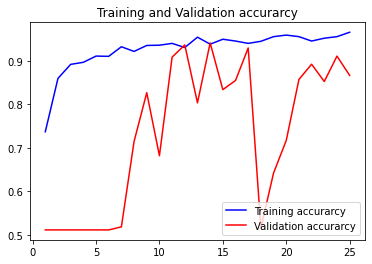

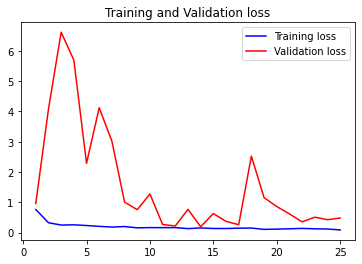

In [ ]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical

# Get the InceptionV3 model so we can do transfer learning
base_inception = InceptionV3(weights='imagenet', include_top=False, 
                             input_shape=(128, 128, 3))
                             
# Add a global spatial average pooling layer
out = base_inception.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(n_classes, activation='softmax')(out)
model = Model(inputs=base_inception.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"]) 
#model.summary()

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=25, verbose=1
    )

Epoch 1/25
53/53 [==============================] - 286s 5s/step - loss: 0.7537 - accuracy: 0.5134 - val_loss: 0.6936 - val_accuracy: 0.1145
Epoch 2/25
25/53 [=============>................] - ETA: 1:57 - loss: 0.6934 - accuracy: 0.4891

In [ ]:
def Res_Plot_Test_Save(name):
    print("[INFO] Plotting model accuracy and Loss")
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    #Train and validation accuracy
    plt.plot(epochs, acc, 'b', label='Training accurarcy')
    plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
    plt.title('Training and Validation accurarcy')
    plt.legend()

    plt.figure()
    #Train and validation loss
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()
    
    print("[INFO] Calculating model accuracy")
    scores = model.evaluate(x_test, y_test)
    print(f"Test Accuracy: {scores[1]*100}")
    
Res_Plot_Test_Save('Inception_ModelV3_(Imagenet_Weights).h5')

In [ ]:
from keras.models import Model
from keras import applications
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical

# Get the Resnet model so we can do transfer learning
base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (128,128,3))
                             
# Add a global spatial average pooling layer
out = base_model.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(n_classes, activation='softmax')(out)
model = Model(inputs=base_model.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"]) 



In [ ]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

In [ ]:
Res_Plot_Test_Save('Resnet_With_Imagenet_Weingts.h5')

In [ ]:
from keras.applications import vgg16
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical

# Get the Resnet model so we can do transfer learning
vgg = vgg16.VGG16(weights= None, include_top=False, input_shape= (128,128,3))
                             
# Add a global spatial average pooling layer
out = base_model.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(n_classes, activation='softmax')(out)
model = Model(inputs=base_model.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"]) 

In [ ]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=25, verbose=1
    )

In [ ]:
Res_Plot_Test_Save('VGG16_With_Imagenet_Weingts.h5')